# Brain-Computer Interfaces

Electroencephalography (EEG) data was recorded during a copy-spelling BCI Experiment at the [Berlin BCI group](http://www.bbci.de).

The data set consists preprocessed EEG data $X\in R^{5\times 62 \times 5322}$ and stimulus labels $Y\in R^{2\times 5322}$ 
during a copy-spelling paradigm with a P300 speller. The data matrix X contains 5 selected time windows of EEG activity at 62 electrodes after a visual stimulus was presented on the screen in front of the subject. If the first row of $Y$ is 1, the stimulus was a target stimulus, if the second row of $Y$ is 1, the stimulus was a non-target stimulus. 

In [1]:
import pylab as pl
import scipy as sp
import numpy as np
from scipy.linalg import eig
from scipy.io import loadmat
from sklearn.model_selection import train_test_split

def load_data(fname):
    # load the data
    data = loadmat(fname)
    # extract images and labels
    X = data['X']
    Y = data['Y']
    # collapse the time-electrode dimensions
    X = np.reshape(X,(X.shape[0]*X.shape[1],X.shape[2])).T
    # transform the labels to (-1,1)
    Y = np.sign((Y[0,:]>0) -.5)
    return X,Y

X,Y = load_data(fname='bcidata.mat')

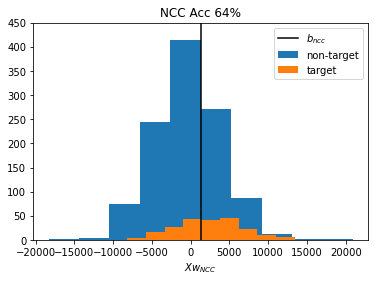

In [2]:
def ncc_fit(X, Y):
    '''
    Train a nearest centroid classifier for N data points in D dimensions
    
    Input: 
    X N-by-D Data Matrix
    Y label vector of length N, labels are -1 or 1
    Output: 
    w weight vector of length D
    b bias vector of length D
    '''
    # class means
    # IMPLEMENT CODE HERE
    mupos = X[Y == 1,:].mean(axis=0)
    muneg = X[Y == -1,:].mean(axis=0)
    
    w = mupos - muneg
    b = (w.dot(mupos) + w.dot(muneg))/2.
    # return the weight vector
    return w,b
X_train, X_test, Y_train, Y_test = train_test_split(X,Y)

w_ncc, b_ncc = ncc_fit(X_train, Y_train)

pl.hist(X_test[Y_test<0, :] @ w_ncc)
pl.hist(X_test[Y_test>0, :] @ w_ncc)
pl.plot([b_ncc, b_ncc], [0, 500], color='k')
pl.xlabel('$Xw_{NCC}$')
pl.legend(('$b_{ncc}$','non-target','target'))
pl.ylim([0, 450])
acc = int((np.sign(X_test @ w_ncc - b_ncc)==Y_test).mean()*100)
pl.title(f"NCC Acc {acc}%");

In [3]:
def lda_fit(X,Y):
    '''
    Train a Linear Discriminant Analysis classifier
    
    Input: 
    X N-by-D Data Matrix
    Y label vector of length N, labels are -1 or 1
    Output: 
    w weight vector of length D
    b bias vector of length D
    '''
    # class means
    mupos = X[Y == 1,:].mean(axis=0)
    muneg = X[Y == -1,:].mean(axis=0)
    
    # D-by-D inter class covariance matrix (signal)
    Sinter = np.outer(muneg - mupos, muneg - mupos)
    # D-by-D intra class covariance matrices (noise)
    Sintra = np.zeros((X.shape[1], X.shape[1]))
    
    for i in range(0, X.shape[0]):
        if Y[i] == -1:            
            Sintra += np.outer(X[i] - muneg, (X[i] - muneg).T)
        else:
            Sintra += np.outer(X[i] - mupos, (X[i] - mupos).T)
            
    # solve eigenproblem
    eigvals, eigvecs = sp.linalg.eig(Sinter,Sintra)
    w = eigvecs[:,eigvals.argmax()]
    # bias term
    b = (w.dot(mupos) + w.dot(muneg))/2.
    # return the weight vector
    return w,b

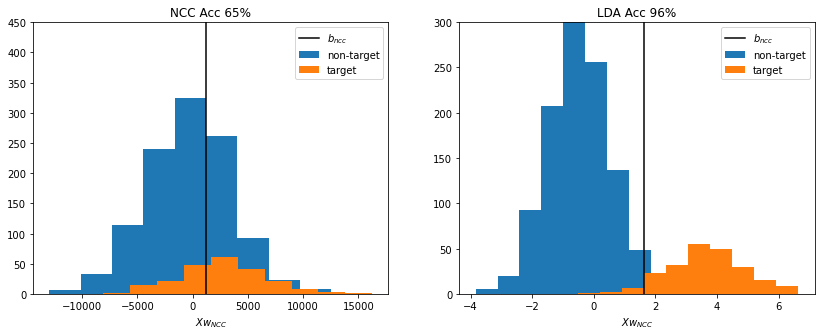

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y)

w_ncc, b_ncc = ncc_fit(X_train, Y_train)
w_lda,b_lda = lda_fit(X_train,Y_train)

pl.figure(figsize=[14,5])
pl.subplot(1,2,1)
pl.hist(X_test[Y_test<0, :] @ w_ncc)
pl.hist(X_test[Y_test>0, :] @ w_ncc)
pl.plot([b_ncc, b_ncc], [0, 500], color='k')
pl.xlabel('$Xw_{NCC}$')
pl.legend(('$b_{ncc}$','non-target','target'))
pl.ylim([0, 450])
acc = int((np.sign(X_test @ w_ncc - b_ncc)==Y_test).mean()*100)
pl.title(f"NCC Acc {acc}%");

pl.subplot(1,2,2)
pl.hist(X_test[Y_test<0, :] @ w_lda)
pl.hist(X_test[Y_test>0, :] @ w_lda)
pl.plot([b_lda, b_lda], [0, 500], color='k')
pl.xlabel('$Xw_{NCC}$')
pl.legend(('$b_{ncc}$','non-target','target'))
pl.ylim([0, 300])
acc = int((np.sign(X_test @ w_lda - b_lda)==Y_test).mean()*100)
pl.title(f"LDA Acc {acc}%");